In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from PIL import Image

In [0]:
feature_extractor = keras.applications.vgg19.VGG19(include_top=False, input_shape=(600, 600, 3))

In [0]:
new_layers = []

for i, layer in enumerate(feature_extractor.layers):
    if isinstance(layer, keras.layers.MaxPooling2D):
        avg_pool = keras.layers.AvgPool2D()
        avg_pool.set_weights(layer.get_weights())
    
        new_layers.append(avg_pool)
    else:
        new_layers.append(layer)

feature_extractor_avg = keras.Sequential(layers=new_layers)


In [0]:
feature_extractor_avg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, 150, 150, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 150, 150, 256)     2

In [0]:
def img_to_array(path):
    img = keras.preprocessing.image.load_img(path, target_size=(600, 600))
    arr = keras.preprocessing.image.img_to_array(img)
    return keras.applications.vgg19.preprocess_input(arr)

def array_to_image(arr):
    return keras.preprocessing.image.array_to_img(arr)

def vgg19_deprocess_img(processed_img):
    x = processed_img.copy()

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    return np.clip(x, 0, 255).astype(np.uint8)


In [0]:
def extract_features(inputs, layers):
    features = dict.fromkeys(layers)
    
    inputs = tf.expand_dims(inputs, 0)
    activations = [inputs]
        
    for layer in feature_extractor_avg.layers:
        activations.append(layer(activations[-1]))
        
        if layer.name in layers:
            features[layer.name] = activations[-1]
            
    return features

In [0]:
def content_loss(content, gen, layer='block5_conv2'):
    content_features = extract_features(content, (layer,))[layer]
    gen_features = extract_features(gen, (layer,))[layer]
    
    loss = tf.reduce_mean((gen_features - content_features) ** 2)
    
    return 0.5 * loss

def layer_style_loss(style_features, gen_features):
    style_features = style_features[0]
    gen_features = gen_features[0]

    # Number of channels
    n_c = style_features.shape[2]
    
    # Feature map size
    fm_size = gen_features.shape[0] * gen_features.shape[1]
    
    style_features = tf.reshape(style_features, (fm_size, n_c))
    gen_features= tf.reshape(gen_features, (fm_size, n_c))
   
    style_features = tf.transpose(style_features)
    gen_features = tf.transpose(gen_features)
    
    gram_eq = 'ik,jk->ij'
    style_gram = tf.einsum(gram_eq, style_features, style_features)
    gen_gram = tf.einsum(gram_eq, gen_features, gen_features)
    
    loss = tf.norm(style_gram - gen_gram) ** 2
    norm_factor = 1 / (4 * (n_c ** 2) * (fm_size ** 2))
    
    return loss * norm_factor

def style_loss(style, gen, layers):
    style_features = extract_features(style, layers)
    gen_features = extract_features(gen, layers)
    
    style_loss = 0
    weight = 1.0 / len(layers)

    for layer in layers:
        style_loss += layer_style_loss(gen_features[layer],
                                       style_features[layer]) * weight 

    return style_loss

def nst_loss(gen, content, style):
    alpha = 1e-3

    style_layers = ('block1_conv1', 'block2_conv1', 'block3_conv1',
                    'block4_conv1','block5_conv1',)

    return 1e4 * content_loss(content, gen) + style_loss(style, gen, style_layers) * 1e-2

In [0]:
content = tf.Variable(img_to_array('./data/baku.jpg'))
style = tf.Variable(img_to_array('./data/starry_night.jpg'))

image = np.random.uniform(10, 200, size=(600, 600, 3))
image = keras.applications.vgg19.preprocess_input(image)
image = tf.Variable(image.astype(np.float32))

# train
n_epochs = 400

optim = keras.optimizers.Adam(learning_rate=10, beta_1=0.99, epsilon=1e-1)

for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        total_loss = nst_loss(image, content, style)

    grad = tape.gradient(total_loss, image)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{n_epochs} - max grad: {tf.reduce_max(grad):.5f}\
                total loss: {total_loss/1000:.4f}k')
    
    optim.apply_gradients([(grad, image)])

(-0.5, 599.5, 599.5, -0.5)

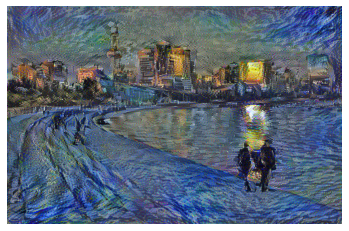

In [0]:
np_image = vgg19_deprocess_img(image.numpy())

plt.imshow(np_image, aspect='auto')
plt.grid(False)
plt.axis('off')

In [0]:
img = Image.fromarray(np_image)
img.save('result_baku.png')